In [1]:
# How many genes pass our filters? And other assorted questions
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du

In [2]:
# load relevant data
# TODO: this needs to generalize to more than just the top 50 genes
# can also probably decouple loading genes and loading mutation data
print('Loading gene label data...', file=sys.stderr)
genes_df = du.load_top_50()
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data
rnaseq_df = du.load_expression_data(verbose=True)

Loading gene label data...
Loading pan-cancer data from cached pickle file...
Loading gene expression data...


In [3]:
print(rnaseq_df.shape)
rnaseq_df.iloc[:5, :5]

(11060, 16148)


,1,10,100,1000,10000
sample_id,,,,,
TCGA-02-0047-01,125.0,10.40,136.0,2300.0,1300.0
TCGA-02-0055-01,392.0,1.12,222.0,1820.0,903.0
TCGA-02-2483-01,272.0,4.64,256.0,2890.0,1320.0
TCGA-02-2485-01,83.9,20.00,129.0,6970.0,10100.0
TCGA-02-2486-01,108.0,3.66,205.0,2250.0,873.0


In [4]:
mutation_genes = set(mutation_df.columns)
copy_loss_genes = set(copy_loss_df.columns)
copy_gain_genes = set(copy_gain_df.columns)
overlap_genes = mutation_genes.intersection(copy_loss_genes.intersection(copy_gain_genes))
print('Genes with mutation information: {}'.format(len(overlap_genes)))

Genes with mutation information: 19660


In [5]:
cancer_types_df = pd.read_csv(
    Path(cfg.data_dir, 'tcga_sample_counts.tsv').resolve(),
    sep='\t'
)
print('Total cancer type/mutation combinations: {}'.format(cancer_types_df.shape[0] * len(overlap_genes)))
cancer_types_df.head()

Total cancer type/mutation combinations: 648780


,cancertype,n =
0,BRCA,1218
1,KIRC,606
2,LUAD,576
3,THCA,572
4,UCEC,567


In [34]:
def filter_cancer_types(gene, y_df, sample_freeze, mutation_burden):
    # copies most code from process_y_matrix in pancancer_utilities.tcga_utilities
    # 
    # note this is not including copy number variants, to do that we have to
    # know oncogene/TSG status for every gene (need to figure out where to get
    # this info)
    y_df = pd.DataFrame(y_df)
    y_df.columns = ['status']
    y_df = (
        y_df.merge(
            sample_freeze, how='left', left_index=True, right_on='SAMPLE_BARCODE'
        )
        .set_index('SAMPLE_BARCODE')
        .merge(mutation_burden, left_index=True, right_index=True)
    )
    disease_counts_df = pd.DataFrame(y_df.groupby('DISEASE').sum()['status'])
    disease_proportion_df = disease_counts_df.divide(
        y_df['DISEASE'].value_counts(sort=False).sort_index(), axis=0
    )
    filter_disease_df = (disease_counts_df > cfg.filter_count) & (disease_proportion_df > cfg.filter_prop)
    disease_proportion_df['disease_included'] = filter_disease_df
    disease_proportion_df['count'] = disease_counts_df['status']
    filter_disease_df.columns = ['disease_included']
    return filter_disease_df, disease_proportion_df


def get_all_valid_combos():
    # not currently using this function
    valid_combos_df = pd.DataFrame()
    counter = 0
    for gene in overlap_genes:
        filter_df, _ = filter_cancer_types(gene, mutation_df.loc[:, gene],
                                           sample_freeze_df, mut_burden_df)
        valid_df = (
            filter_df.query('disease_included')
            .drop(['disease_included'], axis='columns')
            .reset_index()
            .rename({'DISEASE': 'disease'}, axis='columns')
        )
        valid_df['gene'] = gene
        if len(valid_df) > 0:
            valid_combos_df = pd.concat((valid_combos_df, valid_df))
        counter += 1
        if counter % 500 == 0:
            print('{} done'.format(counter), file=sys.stderr)
    print('done.', file=sys.stderr)
    return valid_combos_df

def get_top_valid_combos():
    top_genes_combos_df = pd.DataFrame()
    top_genes_df = du.load_top_50()
    for gene in top_genes_df['gene']:
        _, status_df = filter_cancer_types(gene, mutation_df.loc[:, gene],
                                           sample_freeze_df, mut_burden_df)
        status_df = status_df.reset_index()
        status_df['gene'] = gene
        status_df.rename({'DISEASE': 'disease'}, axis='columns', inplace=True)
        top_genes_combos_df = pd.concat((top_genes_combos_df, status_df))
    return top_genes_combos_df 

test_df = get_top_valid_combos()
test_df.head()

,disease,status,disease_included,count,gene
0,ACC,0.197368,False,15,TP53
1,BLCA,0.492462,True,196,TP53
2,BRCA,0.348624,True,342,TP53
3,CESC,0.080882,True,22,TP53
4,CHOL,0.111111,False,4,TP53


In [35]:
top_valid_df = (
    test_df[test_df.disease_included].drop(['disease_included'], axis='columns')
)
print(len(top_valid_df), 'combos out of', 50 *33, 'possibilities ({:.3f}%)'.format(len(top_valid_df) / (50 * 33)))
unique_genes = np.unique(top_valid_df.gene)
print(len(unique_genes), 'genes have valid combinations, out of', top_genes_df.shape[0], 'total')
unique_cancers = np.unique(top_valid_df.disease)
all_cancers = cancer_types_df['cancertype'].values
print(len(unique_cancers), 'cancers have valid combinations, out of', len(all_cancers), 'total')
print(unique_cancers)
print(set(all_cancers) - set(unique_cancers))

536 combos out of 1650 possibilities (0.325%)
50 genes have valid combinations, out of 50 total
24 cancers have valid combinations, out of 33 total
['BLCA' 'BRCA' 'CESC' 'COAD' 'ESCA' 'GBM' 'HNSC' 'KICH' 'KIRC' 'KIRP'
 'LGG' 'LIHC' 'LUAD' 'LUSC' 'OV' 'PAAD' 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD'
 'THCA' 'UCEC' 'UCS']
{'LAML', 'DLBC', 'TGCT', 'CHOL', 'MESO', 'UVM', 'ACC', 'PCPG', 'THYM'}


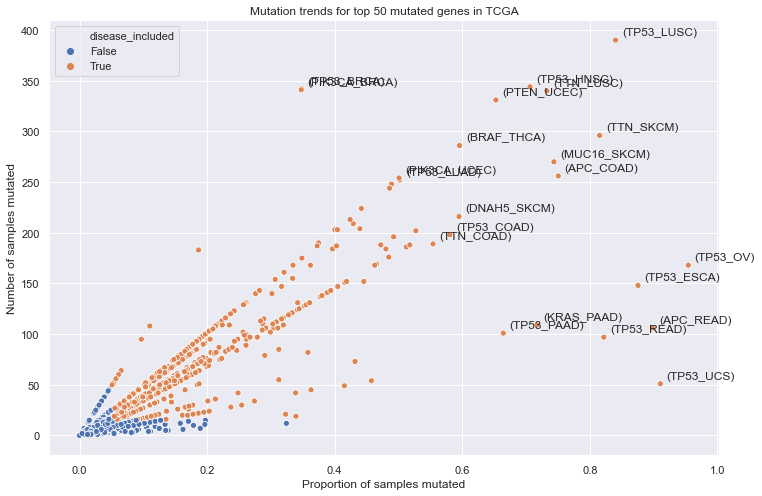

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

test_df['identifier'] = (
    test_df['gene'] + '_' +
    test_df['disease']
)

sns.set({'figure.figsize': (12, 8)})
sns.scatterplot(data=test_df, x='status', y='count', hue='disease_included')
plt.title('Mutation trends for top 50 mutated genes in TCGA')
plt.xlabel('Proportion of samples mutated')
plt.ylabel('Number of samples mutated')


def label_points(x, y, val, ax):
    a = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        if point['x'] > 0.55 or point['y'] > 250:
            ax.text(point['x']+.01, point['y']+5, '(' + str(point['val']) + ')')
            
label_points(test_df['status'], test_df['count'], test_df.identifier, plt.gca())